In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import math
import pandas as pd
import numpy as np
import re
import joblib
# preprocessing
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss

import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install wordcloud


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### We are loading the dataset

In [1]:
import pandas as pd

# Use the Raw URL for the CSV file
url = 'https://raw.githubusercontent.com/Saloni-glit/Medical-dataset/main/mtsamples.csv'
df = pd.read_csv(url)

# Now you should be able to read the CSV file successfully


In [2]:
df.astype(str)
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
df["keywords"].str.split(", ")

0       [allergy / immunology, allergic rhinitis, alle...
1       [bariatrics, laparoscopic gastric bypass, weig...
2       [bariatrics, laparoscopic gastric bypass, hear...
3       [cardiovascular / pulmonary, 2-d m-mode, doppl...
4       [cardiovascular / pulmonary, 2-d, doppler, ech...
                              ...                        
4994                                                  NaN
4995    [allergy / immunology, mucous membranes, conju...
4996                                                  NaN
4997                                                  NaN
4998                                                  NaN
Name: keywords, Length: 4999, dtype: object

# Text Preparation Functions

## text_prepare

### Description
This function prepares the input text by performing the following operations:
- Converts the text to lowercase.
- Replaces specific symbols defined by `REPLACE_BY_SPACE_RE` with spaces.
- Deletes symbols matching the pattern defined by `BAD_SYMBOLS_RE` from the text.
- Removes stopwords from the text.

### Parameters
- `text`: Input text to be prepared.




In [ ]:
def text_prepare(text):

    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@\-,.;#&]')
    BAD_SYMBOLS_RE = re.compile('[0-9][0-9a-z ][#+_]{1,}')
    STOPWORDS = set(stopwords.words('english'))

    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    words = text.split()
    i = 0
    while i < len(words):
        if words[i] in STOPWORDS:
            words.pop(i)
        else:
            i += 1
    text = ' '.join(map(str, words))# delete stopwords from text

    return text
def text_prepare_keywords(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@\-.,;#&]')
    BAD_SYMBOLS_RE = re.compile('[0-9][0-9a-z #+%_]')
    STOPWORDS = set(stopwords.words('english'))

    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    words = text.split()
    i = 0
    while i < len(words):
        if words[i] in STOPWORDS:
            words.pop(i)
        else:
            i += 1
    text = ' '.join(map(str, words))# delete stopwords from text

    return text


### Replace Empty Strings in 'keywords' Column

### Description
This operation replaces empty strings in the 'keywords' column with NaN values.

In [ ]:
df['keywords'].replace('', np.nan, inplace=True)
df = df.drop(df[df['transcription'].isna()].index)
df = df.drop(df[df['keywords'].isna()].index)

In [ ]:
df.shape


(3898, 5)

In [ ]:
# df['transcription'] = df['transcription'].str.replace(r'[0-9-A-Z\s]+:', '')
# df['keywords'] = df['keywords'].str.replace(r'[0-9-A-Z\s]+:', '')
# df['keywords'] = df['keywords'].str.replace(r'(, *)?$', '')
# df['keywords'] = df['keywords'].str.replace(r'^( *,)?', '')
# df['keywords'] = df['keywords'].str.replace(r'\s{2,}', '')
# df['keywords'] = df['keywords'].str.replace(r'%', '')
# df.loc[:, 'transcription'] = [text_prepare(x) for x in df['transcription'].values]
# df.loc[:, 'keywords'] = [text_prepare_keywords(x) for x in df['keywords'].values]
df['transcription'] = df['transcription'].str.replace(r'[0-9-A-Z\s]+:', '', regex=True)
df['keywords'] = df['keywords'].str.replace(r'[0-9-A-Z\s]+:', '', regex=True)
df['keywords'] = df['keywords'].str.replace(r'(, *)?$', '', regex=True)
df['keywords'] = df['keywords'].str.replace(r'^( *,)?', '', regex=True)
df['keywords'] = df['keywords'].str.replace(r'\s{2,}', '', regex=True)
df['keywords'] = df['keywords'].str.replace(r'%', '', regex=True)
df.loc[:, 'transcription'] = [text_prepare(x) for x in df['transcription'].values]
df.loc[:, 'keywords'] = [text_prepare_keywords(x) for x in df['keywords'].values]


### Tokenization of 'keywords' Column

### Tokenize 'keywords' Column and Create 'tokens_keywords' Column

### Description
This operation tokenizes the 'keywords' column and creates a new column 'tokens_keywords' containing the tokenized words.


In [ ]:
tokenizer = RegexpTokenizer(r'[\w\'-]+')
df["tokens_keywords"] = df["keywords"].apply(tokenizer.tokenize)
df["tokens_keywords"].head()

0    [allergy, immunology, allergic, rhinitis, alle...
1    [bariatrics, laparoscopic, gastric, bypass, we...
2    [bariatrics, laparoscopic, gastric, bypass, he...
3    [cardiovascular, pulmonary, mode, doppler, aor...
4    [cardiovascular, pulmonary, doppler, echocardi...
Name: tokens_keywords, dtype: object

In [ ]:
df["keyword_count"] = df['keywords'].apply(lambda text: len(text.split(" ")))
df.head()

,description,medical_specialty,sample_name,transcription,keywords,tokens_keywords,keyword_count
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,23 year old white female presents complaint al...,allergy immunology allergic rhinitis allergies...,"[allergy, immunology, allergic, rhinitis, alle...",14
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,difficulty climbing stairs difficulty airline ...,bariatrics laparoscopic gastric bypass weight ...,"[bariatrics, laparoscopic, gastric, bypass, we...",28
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,seen abc today pleasant gentleman 42 years old...,bariatrics laparoscopic gastric bypass heart a...,"[bariatrics, laparoscopic, gastric, bypass, he...",27
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,1 left atrial enlargement left atrial diameter...,cardiovascular pulmonary mode doppler aortic v...,"[cardiovascular, pulmonary, mode, doppler, aor...",27
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1 left ventricular cavity size wall thickness ...,cardiovascular pulmonary doppler echocardiogra...,"[cardiovascular, pulmonary, doppler, echocardi...",33



### Description
This section provides the counts of unique values in the 'keyword_count' column.

In [ ]:
df.keyword_count.value_counts()

16    218
15    200
17    196
18    188
19    181
     ... 
80      2
55      1
86      1
54      1
53      1
Name: keyword_count, Length: 85, dtype: int64


## Description
This section applies Count Vectorizer to convert the 'keywords' column into a document-term matrix (DTM).

### Code
```python
from sklearn.feature_extraction.text import CountVectorizer

# Initialize Count Vectorizer with a custom tokenizer
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(' '))

# Fit and transform the 'keywords' column
keywords_dtm = vectorizer.fit_transform(df['keywords'])

# Get feature names (tags) from the vectorizer
tags = vectorizer.get_feature_names_out()


In [ ]:
# using count vectorizer
# vectorizer = CountVectorizer(tokenizer = lambda x: x.split(' '))

# keywords_dtm = vectorizer.fit_transform(df['keywords'])
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(' '))
keywords_dtm = vectorizer.fit_transform(df['keywords'])
tags = vectorizer.get_feature_names_out()

C:\Users\salon\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
keywords_dtm

<3898x5839 sparse matrix of type '<class 'numpy.int64'>'
	with 68412 stored elements in Compressed Sparse Row format>

In [ ]:
print("Number of data points :", keywords_dtm.shape[0])
print("Number of unique tags :", keywords_dtm.shape[1])

Number of data points : 3898
Number of unique tags : 5839


# Storing the Count of Tags in Each Transcription

In this section, we calculate the count of tags in each transcription and convert the resulting list into a single list.




In [ ]:
# Storing the count of tag in each transcription in the list 'tag_count
tag_quest_count = keywords_dtm.sum(axis=1).tolist()

# converting list of lists into single list,we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print('We have total {} datapoints.'.format(len(tag_quest_count)))
print(tag_quest_count[:5])

We have total 3898 datapoints.
[14, 28, 27, 27, 33]


In [ ]:
df['tag_quest_count']=tag_quest_count

In [ ]:
df

,description,medical_specialty,sample_name,transcription,keywords,tokens_keywords,keyword_count,tag_quest_count
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,23 year old white female presents complaint al...,allergy immunology allergic rhinitis allergies...,"[allergy, immunology, allergic, rhinitis, alle...",14,14
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,difficulty climbing stairs difficulty airline ...,bariatrics laparoscopic gastric bypass weight ...,"[bariatrics, laparoscopic, gastric, bypass, we...",28,28
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,seen abc today pleasant gentleman 42 years old...,bariatrics laparoscopic gastric bypass heart a...,"[bariatrics, laparoscopic, gastric, bypass, he...",27,27
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,1 left atrial enlargement left atrial diameter...,cardiovascular pulmonary mode doppler aortic v...,"[cardiovascular, pulmonary, mode, doppler, aor...",27,27
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1 left ventricular cavity size wall thickness ...,cardiovascular pulmonary doppler echocardiogra...,"[cardiovascular, pulmonary, doppler, echocardi...",33,33
...,...,...,...,...,...,...,...,...
4984,Patient suffered from morbid obesity for many...,Bariatrics,Discharge Summary - Gastric Bypass,morbid obesity bmi 51 morbid obesity bmi 51 la...,bariatrics laparoscopic gastric bypass gastric...,"[bariatrics, laparoscopic, gastric, bypass, ga...",12,12
4985,Patient presented to the Bariatric Surgery Se...,Bariatrics,Bariatric Consult - Surgical Weight Loss - 4,ms 55 year old female presented bariatric surg...,bariatrics jenny craig medifast nutrisystem ri...,"[bariatrics, jenny, craig, medifast, nutrisyst...",35,35
4989,Evaluation for elective surgical weight loss ...,Bariatrics,Bariatric Consult - Surgical Weight Loss - 2,negative stress test four five years ago gets ...,bariatrics elective surgical weight loss surgi...,"[bariatrics, elective, surgical, weight, loss,...",25,25
4993,"Chronic glossitis, xerostomia, probable envir...",Allergy / Immunology,Evaluation of Allergies,55 year old female presents self referred poss...,allergy immunology chronic glossitis xerostomi...,"[allergy, immunology, chronic, glossitis, xero...",22,22


In [ ]:
print ("Maximum no of tag per transcription: %d"%max(tag_quest_count))
print ("Minimum no of tags per transcription: %d"%min(tag_quest_count))
print ("Avg number of tags per transcription: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum no of tag per transcription: 90
Minimum no of tags per transcription: 1
Avg number of tags per transcription: 23.506927


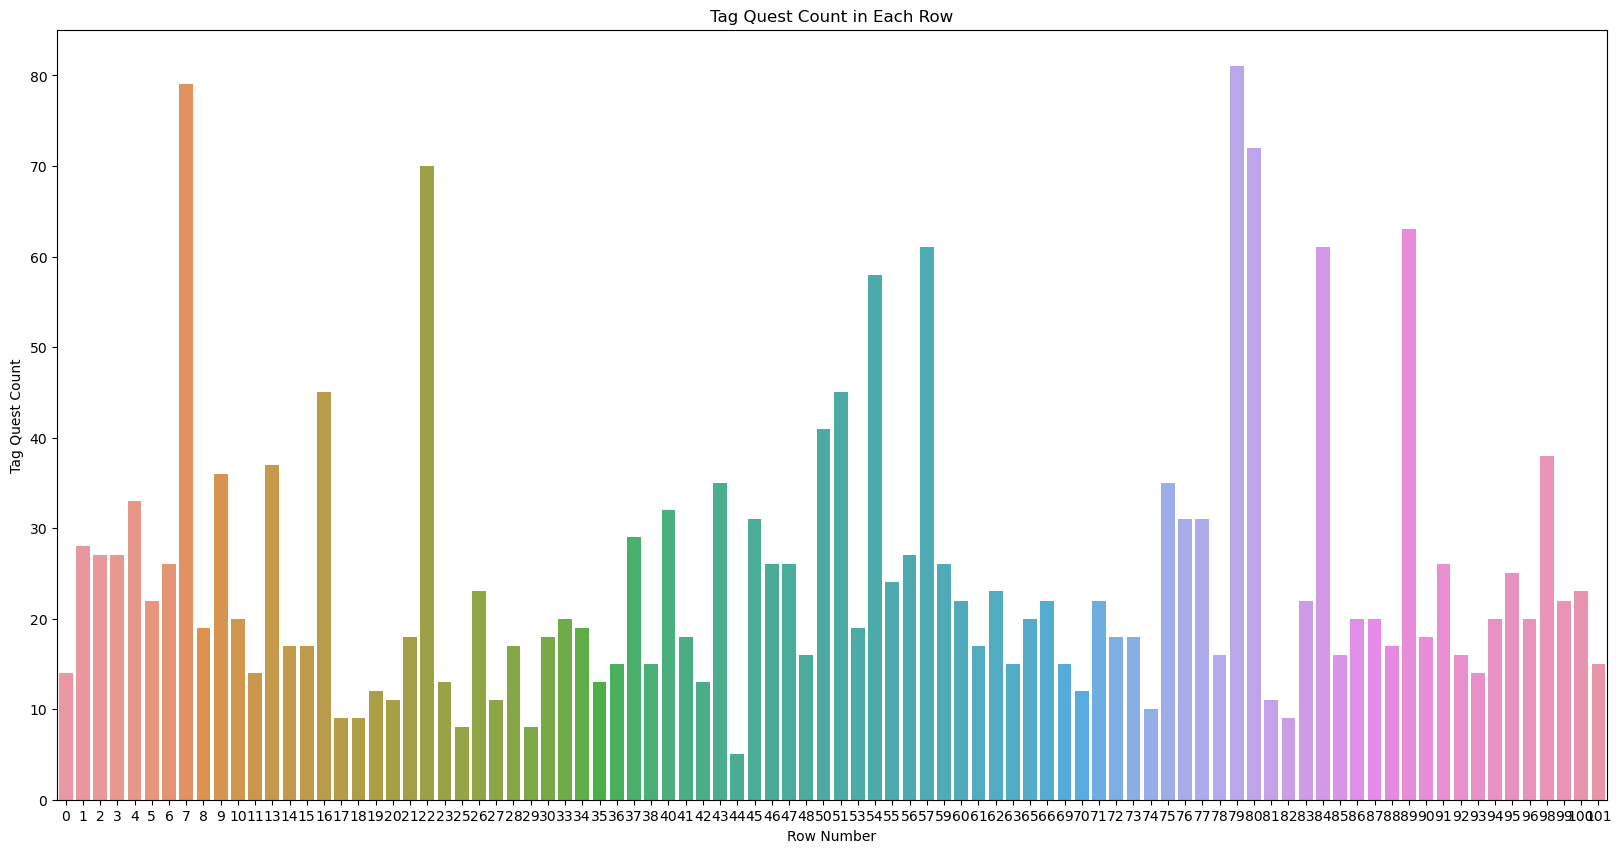

In [ ]:
sns.set_palette("gist_rainbow")

# Plotting the bar graph
plt.figure(figsize=(20, 10))
sns.barplot(x=df.index[:90], y=df['tag_quest_count'][:90])
plt.title("Tag Quest Count in Each Row")
plt.xlabel("Row Number")
plt.ylabel("Tag Quest Count")
plt.show()

# Calculating Tag Frequencies in Document Term Matrix (DTM)

In this section, we calculate the frequencies of tags in the Document Term Matrix (DTM) and store the results in a dictionary.




In [ ]:
#Lets now store the document term matrix in a dictionary.


freqs = keywords_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))



In [ ]:
keywords_dtm


<3898x5839 sparse matrix of type '<class 'numpy.int64'>'
	with 68412 stored elements in Compressed Sparse Row format>

In [ ]:
# Creating a DataFrame with Tags and their Counts
tag_df = pd.DataFrame({'Tags': tags, 'Counts': freqs})
tag_df.head()

,Tags,Counts
0,,81
1,:,220
2,abc,3
3,abd,3
4,abdomen,188


In [ ]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

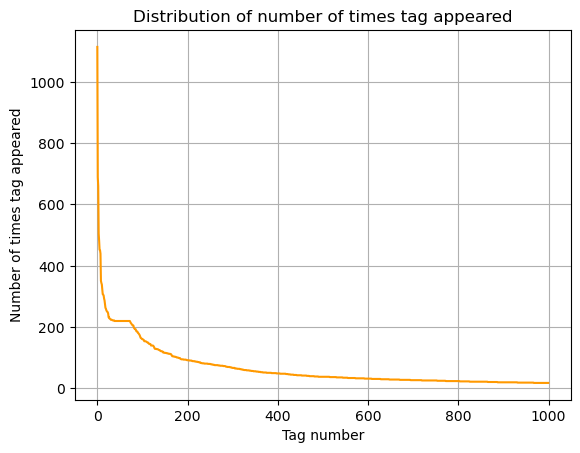

In [ ]:
plt.plot(tag_counts[:1000])
plt.title("Distribution of number of times tag appeared")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

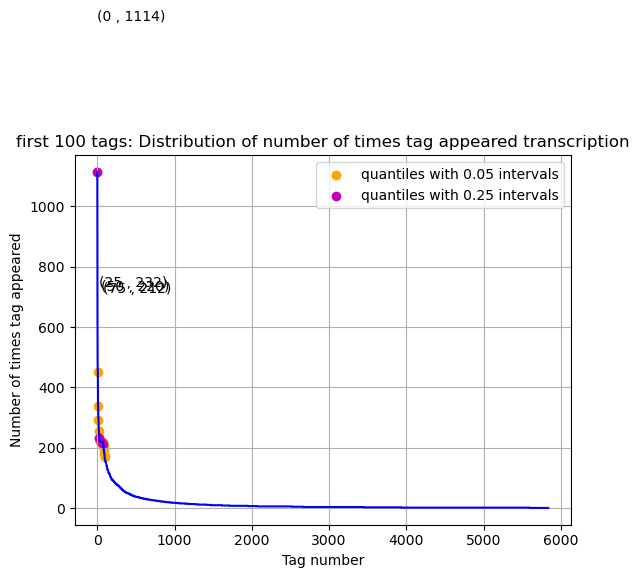

20 [1114  452  339  293  255  232  224  222  220  220  220  220  220  220
  220  212  205  193  181  169]


In [ ]:
plt.plot(tag_counts, c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
#     plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))
     plt.annotate(text="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared transcription')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

### Lets first convert the 'result' dictionary to 'list of tuples' ,Initializing Word Cloud using frequencies of tags.

A word cloud is a data visualization technique used to represent text data in which the size of each word indicates its frequency or importance. In a word cloud, more frequently occurring words are displayed in larger and bolder fonts. It's a way to visually explore and represent the most prominent terms in a corpus of text.


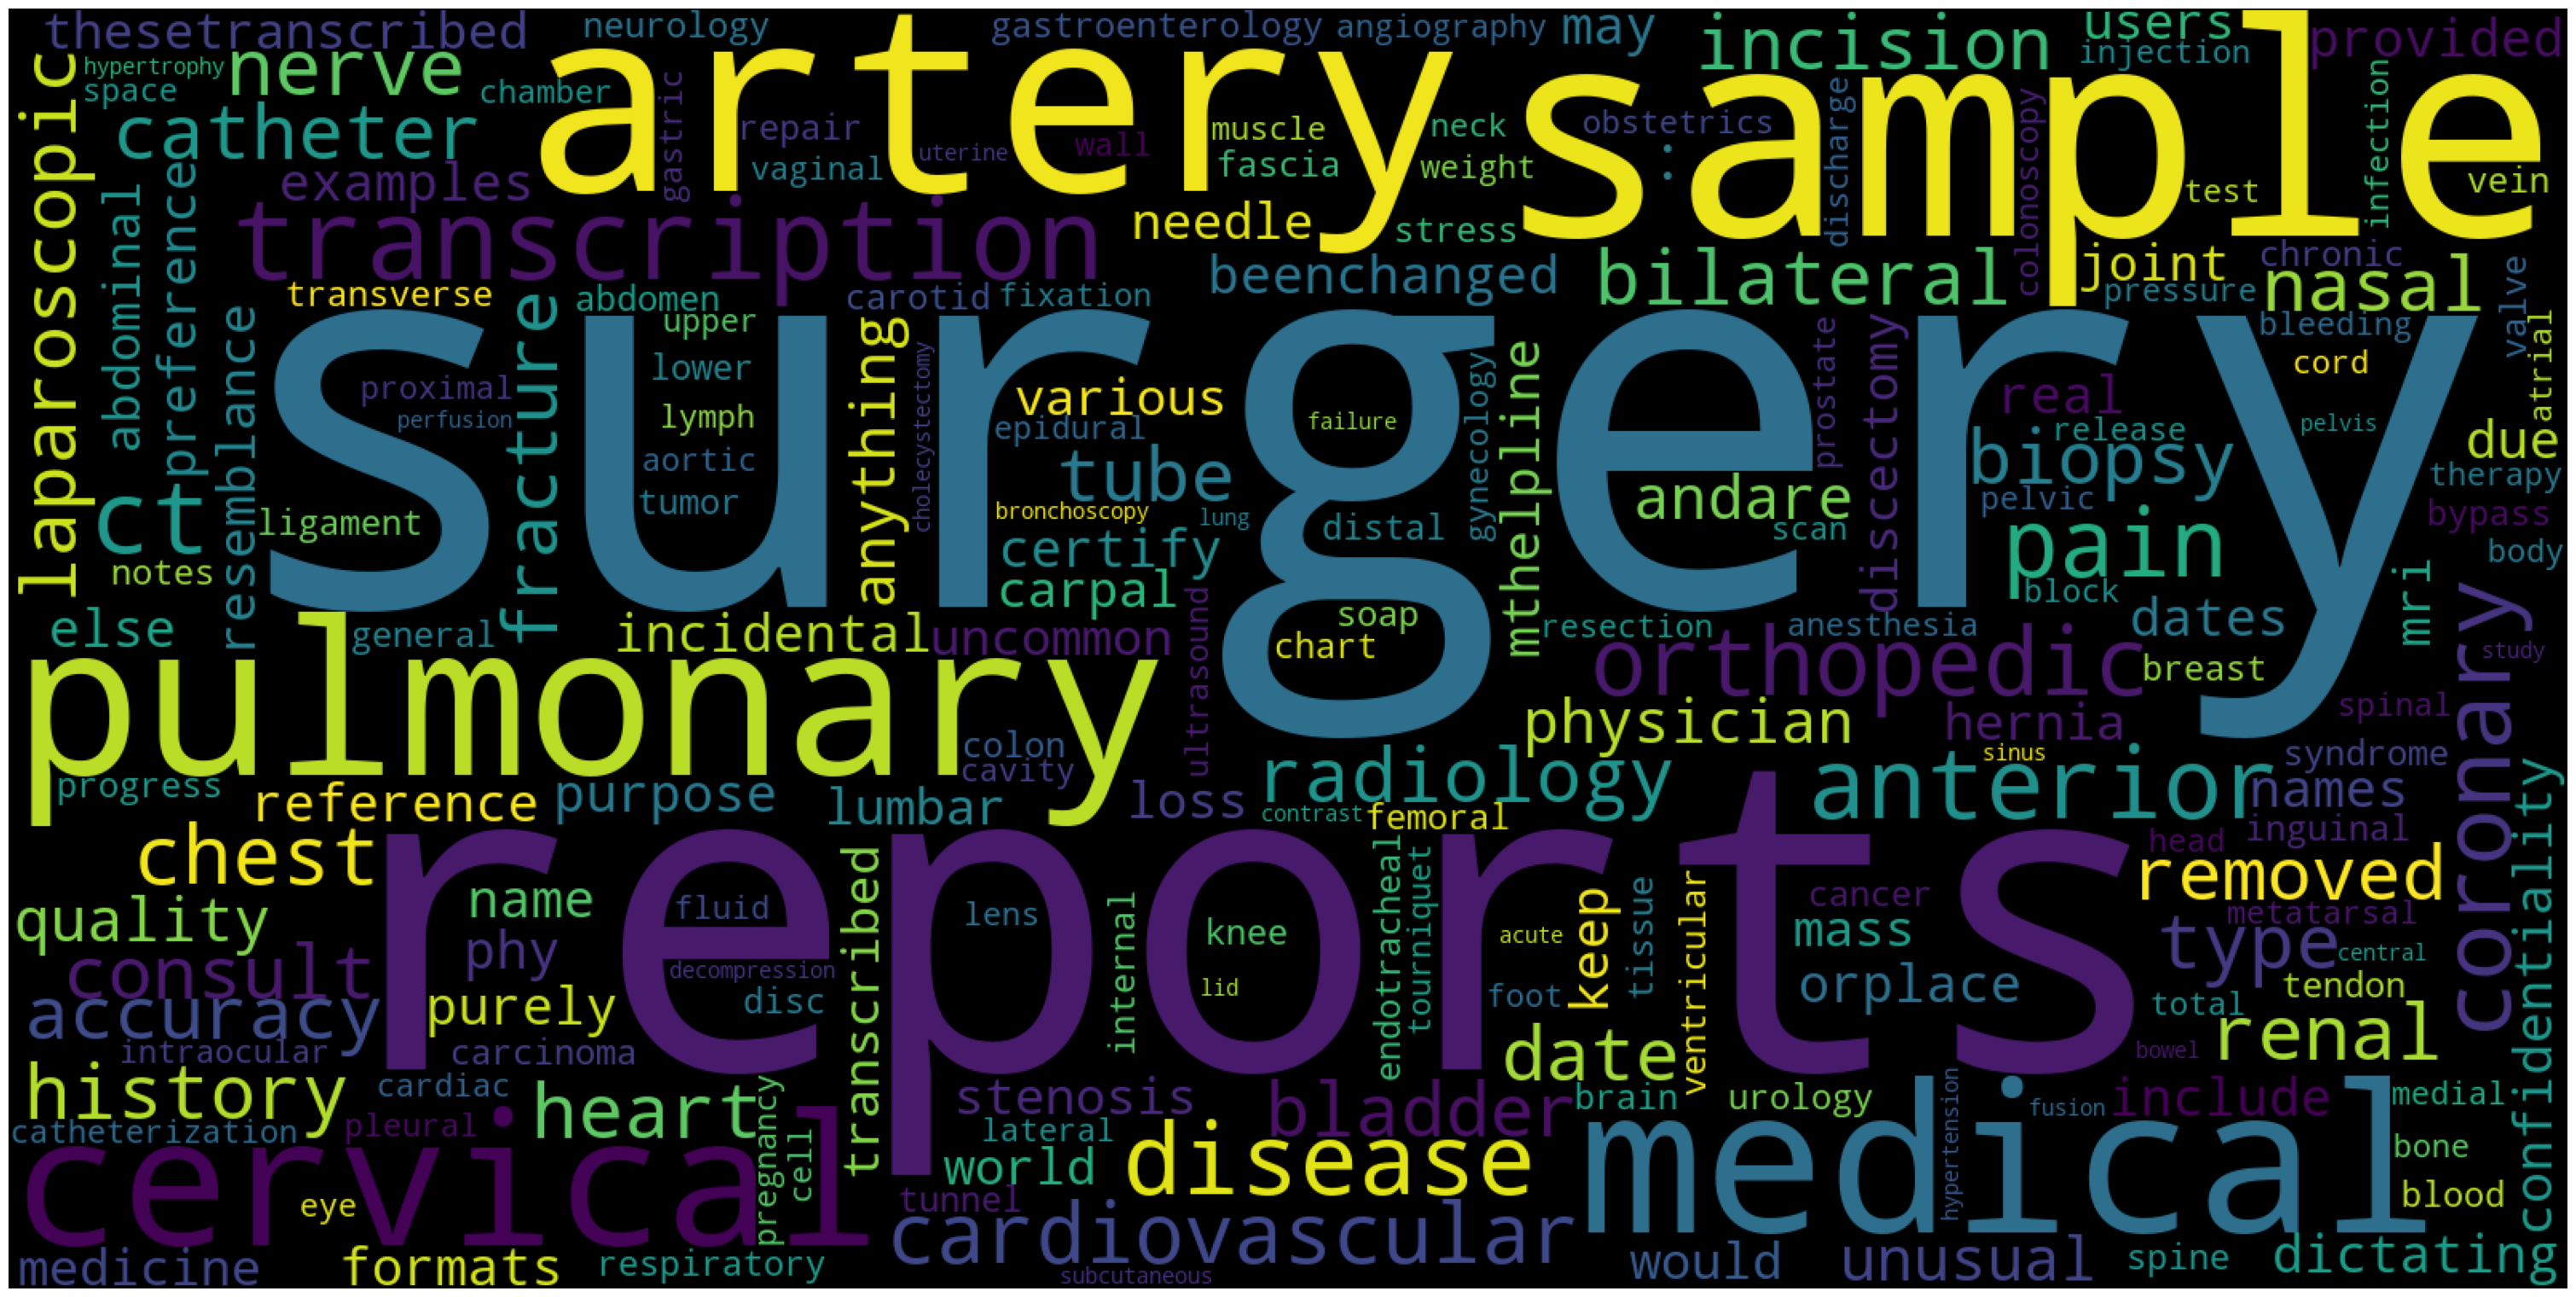

Time taken to run this cell : 0:00:04.153945


In [ ]:
import datetime
from wordcloud import WordCloud
# Ploting word cloud
start = datetime.datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.datetime.now() - start)

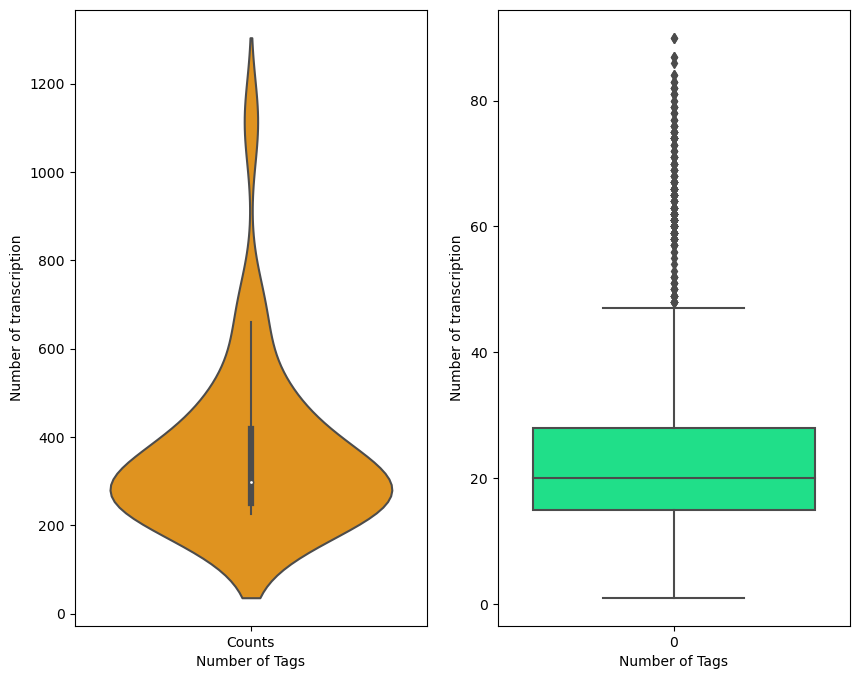

In [ ]:
# Obsetving the quantiles using the violin plot and box .

plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(data = tag_df_sorted.head(30) , )
plt.xlabel("Number of Tags")
plt.ylabel("Number of transcription")

plt.subplot(1,2,2)
sns.boxplot(tag_quest_count, palette='gist_rainbow')
plt.xlabel("Number of Tags")
plt.ylabel("Number of transcription")
plt.show()

In [ ]:
df.drop(['description', 'medical_specialty', 'sample_name', 'tokens_keywords'], axis=1, inplace=True)

In [ ]:
df.head()

,transcription,keywords,keyword_count,tag_quest_count
0,23 year old white female presents complaint al...,allergy immunology allergic rhinitis allergies...,14,14
1,difficulty climbing stairs difficulty airline ...,bariatrics laparoscopic gastric bypass weight ...,28,28
2,seen abc today pleasant gentleman 42 years old...,bariatrics laparoscopic gastric bypass heart a...,27,27
3,1 left atrial enlargement left atrial diameter...,cardiovascular pulmonary mode doppler aortic v...,27,27
4,1 left ventricular cavity size wall thickness ...,cardiovascular pulmonary doppler echocardiogra...,33,33


# Splitting the DataFrame into Train and Test Sets

We use the `sample` method to split the DataFrame `df` into training and testing sets.

This code randomly samples 50% of the data for training (x_train) and 20% for testing (x_test). The frac parameter controls the fraction of data to be sampled, and replace=True allows for replacement during sampling. The random_state ensures reproducibility of the split

x_train=df.sample(frac=0.5, replace=True, random_state=1)
x_test=df.sample(frac=0.2, replace=True, random_state=1)


## Analyzing Keyword Frequencies in Training Data

We use the Natural Language Toolkit (nltk) and seaborn libraries to analyze the frequency distribution of keywords in the training data.

### Calculate the frequency distribution of the first word in each keyword

### Create a DataFrame to store Keywords and their Counts

### Select the top 100 keywords based on their frequency
g = all_genres_df.nlargest(columns="Count", n=100)

### Plot a bar chart to visualize keyword frequencies

### Display a list of all unique keywords
list_of_keywords = list(all_genres.keys())


In [ ]:
import nltk
import seaborn as sns
all_genres = nltk.FreqDist(x_train["keywords"].apply(lambda x: x.split(' ')[0]))
all_genres_df = pd.DataFrame({'Keywords': list(all_genres.keys()), 'Count': list(all_genres.values())})
g = all_genres_df.nlargest(columns="Count", n = 100)
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Keywords")
ax.set(ylabel = 'Count')
plt.show()
list(all_genres.keys())

# Text Classification Model Training using scikit-learn Pipeline

In this code snippet, we demonstrate the training of a text classification model using scikit-learn's Pipeline. The model is a combination of a CountVectorizer, TfidfTransformer, and a OneVsRestClassifier with Stochastic Gradient Descent (SGD) as the base classifier.

1. **Data Preparation:**
   - You split your dataset into training and test sets using the `sample` method, ensuring random sampling and replacement for both sets.
#CountVectorizer : Converts a collection of text documents to into a bag-of-words representation,  
#TfidfTransformer: Transforms a count matrix to a normalized term-frequency or term-frequency times inverse document-frequency representation.
#OneVsRestClassifier:This a strategy for multi-label classification in which a separate classifier is trained for each label.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

# You are extracting the 'transcription' and 'keywords' columns from your training and test datasets and converting them into NumPy arrays.
X_train = np.array(x_train['transcription'])
Y_train = np.array(x_train['keywords'])
X_test = np.array(x_test['transcription'])
Y_test = np.array(x_test['keywords'])

model = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', class_weight="balanced", verbose=1), n_jobs=-1))
                      ])
model.fit(X_train, Y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 OneVsRestClassifier(estimator=SGDClassifier(class_weight='balanced',
                                                             loss='log',
                                                             penalty='l1',
                                                             verbose=1),
                                     n_jobs=-1))])


### We save our trained model using the joblib.dump function. The model is serialized and stored in a file named "pipeline1.pkl" with compression level 9.

In [ ]:
# from sklearn.externals
# This line saves your trained model using the joblib.dump function. The model is serialized and stored in a file named "pipeline1.pkl" with compression level 9.
import joblib
joblib.dump(model, "pipeline1.pkl", compress=9)
prediction = model.predict(X_test)

#      RESULTS

In [ ]:
print("Accuracy :",accuracy_score(Y_test, prediction))
print("Hamming loss ",hamming_loss(Y_test,prediction))


precision = precision_score(Y_test, prediction, average='micro')
recall = recall_score(Y_test, prediction, average='micro')
f1 = f1_score(Y_test, prediction, average='micro')

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(Y_test, prediction, average='macro')
recall = recall_score(Y_test, prediction, average='macro')
f1 = f1_score(Y_test, prediction, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Accuracy : 0.658974358974359
Hamming loss  0.34102564102564104
Micro-average quality numbers
Precision: 0.6590, Recall: 0.6590, F1-measure: 0.6590
Macro-average quality numbers
Precision: 0.5432, Recall: 0.6020, F1-measure: 0.5605


C:\Users\salon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\salon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('Input: '+X_test[1])
prediction_row = model.predict([X_test[1]])
print('Output: '+prediction_row[0])
print('Actual: '+Y_test[1])

Input: infected right hip bipolar arthroplasty status post excision placement antibiotic spacer infected right hip bipolar arthroplasty status post excision placement antibiotic spacer 1 removal antibiotic spacer 2 revision total hip arthroplasty implants 1 hold zimmer trabecular metal 50 mm acetabular shell two 6 5 x 30 mm screws 2 zimmer femoral component 13 5 x 220 mm size aa femoral body 3 32 mm femoral head +0 neck length regional 500 cc none hemovac times one incisional vac times one patient 66 year old female history previous right bipolar hemiarthroplasty trauma subsequently became infected undergone removal prosthesis placement antibiotic spacer currently presents stage ii reconstruction removal antibiotic spacer placement revision total hip patient brought operating room anesthesia personnel placed supine operating table foley catheter inserted formal time obtained identifying correct patient operative site preoperative antibiotics held intraoperative cultures patient placed 